# SLU12: Feature Engineering (aka Real World Data)
---

In this notebook we will cover the following topics:
1. [Tidy data principles](#tidy-data)
2. [Types of data in Pandas](#types-data)
3. [Types of statistical data](#types-statistical)
    1. [Dealing with numerical features](#deal-num)
    2. [Dealing with categorical features](#deal-cat)

> *Happy datasets are all alike; every unhappy dataset is unhappy in its own way.*

(Shamelessly adapted from [Tolstoy's Anna Karenina](https://en.wikipedia.org/wiki/Anna_Karenina_principle).)

# 1. Tidy data principles <a class="anchor" id="tidy-data"></a>

At the beginning of any project, it is critical to structure datasets in a way that facilitates work.

Most datasets are dataframes made up of rows and columns, containing values that belong to a variable and an observation:
* **Variables** contain all values that measure the same thing across observations;
* **Observations** contain all values measured on the same unit (e.g., same person) across variables.

The ideas of ***tidy data*** ([Wickham, 2014](http://vita.had.co.nz/papers/tidy-data.html)) provide a standardized framework to organize and structure datasets, making them easy to manipulate, model and visualize.
1. Each variable forms a column;
2. Each observation forms a row;
3. Each type of observational unit forms a table (or dataframe).

We will be using a preprocessed version of the `avengers` dataset, by [FiveThirtyEight](https://github.com/fivethirtyeight/data/tree/master/avengers).

![](https://ichef.bbci.co.uk/news/800/cpsprodpb/BF0D/production/_106090984_2e39b218-c369-452e-b5be-d2476f9d8728.jpg)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
avengers = pd.read_csv('data/avengers.csv')
avengers.head()

,Name,Active,Gender,Membership,Universe,Appearances,TotalDeaths,TotalReturns
0,"Henry Jonathan ""Hank"" Pym",YES,MALE,Full,Earth-616,1269,1,0
1,Janet van Dyne,YES,FEMALE,Full,Earth-616,1165,1,1
2,"Anthony Edward ""Tony"" Stark",YES,MALE,Full,Earth-616,3068,1,1
3,Robert Bruce Banner,YES,MALE,Full,Earth-616,2089,1,1
4,Thor Odinson,YES,MALE,Full,Earth-616,2402,2,1


# 2. Types of data in Pandas <a class="anchor" id="types-data"></a>

## 2.1. Numerical and object dtypes

As stated above, a dataset is a collection of values, usually either numbers (quantitative) or strings (qualitative).

In [3]:
avengers.dtypes

Name            object
Active          object
Gender          object
Membership      object
Universe        object
Appearances      int64
TotalDeaths      int64
TotalReturns     int64
dtype: object

Pandas main data types are:
* Numeric (`int`, `float`);
* Datetime (`datetime`, `timedelta`);
* String (`object`).

The convenient `select_dtypes` method allows us to select variables (columns in our dataframe) by data type.

In [4]:
(avengers.select_dtypes(include='object')
         .head(3))

,Name,Active,Gender,Membership,Universe
0,"Henry Jonathan ""Hank"" Pym",YES,MALE,Full,Earth-616
1,Janet van Dyne,YES,FEMALE,Full,Earth-616
2,"Anthony Edward ""Tony"" Stark",YES,MALE,Full,Earth-616


## 2.2. Category dtype

Pandas provide us with a `category` dtype for categorical data:
* It allows to easily identify categorical columns, which are recognized by other Python libraries;
* Converting a string variable with a few different values to a categorical variable saves memory;
* By converting to a categorical we can specify an order on the categories.

Let's consider a categorical feature: `Universe`.

In [5]:
avengers_cat = avengers.copy()
avengers_cat = avengers_cat.assign(Universe=avengers['Universe'].astype('category'))

avengers_cat.describe(include='category')

,Universe
count,155
unique,7
top,Earth-616
freq,144


Categorical data has a `categories` and an `ordered` property:
* `Series.cat.categories` prints the different values (or levels) the variable can take on;
* `Series.cat.ordered` prints whether the categorical variable has a natural order or not (hint: if it has, it's not purely categorical).

In [6]:
avengers_cat['Universe'].cat.categories

Index(['Earth-13034', 'Earth-616', 'Earth-6311', 'Earth-691', 'Earth-8009',
       'Earth-921', 'Earth-96020'],
      dtype='object')

In [7]:
avengers_cat['Universe'].cat.ordered

False

### Ordinal data

Ordinal statistical data refers to categories that have a natural order, but the distance between them is not known.

We will use the `Membership` variable as an example since it appears to be an order in the degree of commitment of our avengers.

We can also use the `category` dtype.

In [8]:
avengers_ord = avengers.copy()
avengers_ord = avengers_ord.assign(Membership=avengers['Membership'].astype('category'))

avengers_ord['Membership'].cat.categories

Index(['Academy', 'Full', 'Honorary', 'Probationary'], dtype='object')

However, this time we need to set the order for our categories, since there is one! The `category` datatype is flexible enough to accommodate this.

In [9]:
ordered_cats = ['Honorary', 'Academy', 'Probationary', 'Full']
avengers_ord = avengers_ord.assign(Membership=avengers_ord['Membership'].cat.set_categories(ordered_cats, ordered=True))

avengers_ord['Membership'].min(), avengers_ord['Membership'].max()

('Honorary', 'Full')

Again, remember that our models need variables in numeric form, in order to be able to make sense of them.

The `category` datatypes deals with this gracefully for us.

In [10]:
(avengers_ord.assign(Membership=avengers_ord['Membership'].cat.codes)
         .sample(n=5))

,Name,Active,Gender,Membership,Universe,Appearances,TotalDeaths,TotalReturns
6,Steven Rogers,YES,MALE,3,Earth-616,3458,1,1
137,Marcus Milton,YES,MALE,3,Earth-13034,65,1,0
118,Ken Mack,NO,MALE,1,Earth-616,59,1,0
10,Jacques Duquesne,NO,MALE,3,Earth-616,115,1,1
81,Carl Lucas,YES,MALE,3,Earth-616,886,0,0


However, and as usual, there is a trade-off here:
* If we assign integer values to our ordinal categories we are *imposing the assumption* that they are equally spaced;
* If we convert them to dummy variables, we will lose the constraint with their order.

Later in this notebook, we will see a better way to encode categorical variables into numerical ones.

# 3. Types of statistical data <a class="anchor" id="types-statistical"></a>

There are two main types of statistical data:
1. Numerical;
2. Categorical.

## 3.1. Dealing with numerical data <a class="anchor" id="deal-num"></a>

Numerical data is information that is measurable. It's always collected in number form, although not all data in number form is numerical.

Some of the things we can do with numerical data:
* Mathematical operations (e.g., addition, distances and the normalization above);
* Sort it in ascending or descending order.

**Discrete data**

Discrete data take on certain values, although the list of values may be finite or not. 

`TotalDeaths` and `TotalReturns` in our `avengers` data are discrete variable.

**Continuous data**

Continuous data can take any value within a range: `Appearances` is an example in our data.

### 3.1.1. Introducing sklearn-like transformers

In a Data Science project, you will deal with a dataset, on which you will apply transformations (*feature engineering!*) and, after that, you will train your Machine Learning model. You have already encountered some of these transformations: for example, imputing the missing values on a given column (using pandas `fillna` method). After your model is trained, you are going to use it in a separate dataset to make predictions (either to evaluate the performance of your model on a test set or to make predictions on new, unlabeled data).

If, for example, you are filling the missing values of a numerical feature with a fixed value (say `0`), then it is trivial to apply the same transformation on new, unseen data. But imagine that instead you are filling the missing values with the median value of that feature. How do you apply that transformation in practice?

You have to do it in two steps:
* You compute the median of that feature for the *training data* and fill the missing values with that value;
* For new unseen data (e.g. the test set), you just fill the missing value with the median you calculated for the *training data*.

This process is greatly facilitated by using `sklearn`-like **transformers**, which have two standard methods:
* The `.fit()` method goes through the data and creates a mapping;
* Then`.transform()` transforms the data using this mapping, failing gracefully you when strange things happen (e.g., unseen values or categories).

Also, they can used in very convenient ways with other `sklearn` utilities and a typical workflow.

For numerical data, we will introduce the following transformers, from `sklearn.preprocessing`:

In [11]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

### 3.1.2. Discretization of numerical data

#### Binning

Discretization is the transformation of continuous data into *intervals* or *bins*. Despite its name, it can be applied on discrete data to put them on a fixed number of bins.

Let's try it in the `Appearances` field, which has the following distribution:

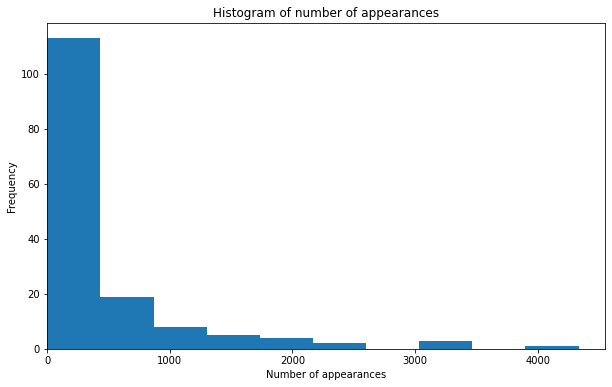

In [12]:
avengers['Appearances'].plot.hist(bins=10, figsize=(10, 6));
plt.xlim(0);
plt.xlabel('Number of appearances');
plt.title('Histogram of number of appearances');

The histogram above shows the distribution of this field by splitting the instances into 10 bins, for the purpose of the plot. The [`KBinsDiscretizer` transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer) will do the same thing, at the level of the data.

In the following, we will create a new feature called `Appearances_bins` containing 10 bins, from 0 to 9, with the instances uniformly distributed.

In [13]:
# save column as a dataframe, as required by the transformer
X = avengers[['Appearances']]

# initialize transformer with desired options
binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# fit transformer to data
binner.fit(X)

# create new feature by transforming the data
avengers['Appearances_bins'] = binner.transform(X)

The histogram will look the same as above, but the feature values will range from 0 to 9 instead.

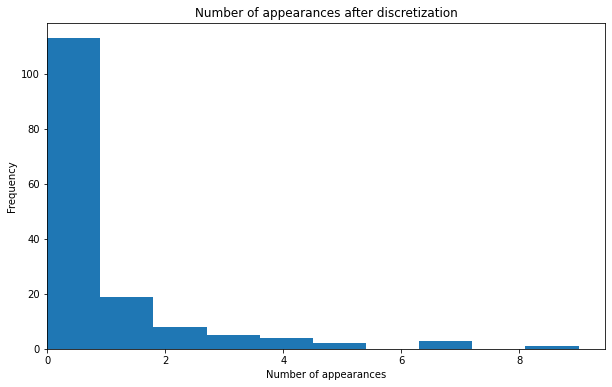

In [14]:
avengers['Appearances_bins'].plot.hist(figsize=(10, 6));
plt.xlim(0);
plt.xlabel('Number of appearances');
plt.title('Number of appearances after discretization');

If you want to know the original values for the edges of each bin, call:

In [15]:
binner.bin_edges_

array([array([2.0000e+00, 4.3510e+02, 8.6820e+02, 1.3013e+03, 1.7344e+03,
              2.1675e+03, 2.6006e+03, 3.0337e+03, 3.4668e+03, 3.8999e+03,
              4.3330e+03])                                               ],
      dtype=object)

You can play with the options of the transformer to obtain different results.

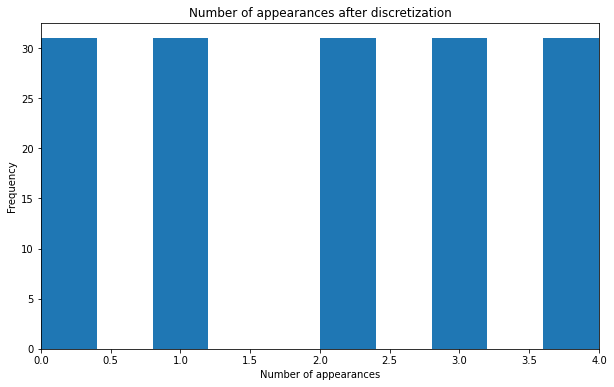

In [16]:
# initialize transformer with desired options
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

# save data to bin
X = avengers[['Appearances']]

# fit transformer to data
binner.fit(X)

# create new feature by transforming the data
avengers['Appearances_bins_quartiles'] = binner.transform(X)

# plot histogram
avengers['Appearances_bins_quartiles'].plot.hist(figsize=(10, 6));
plt.xlim(0,4);
plt.xlabel('Number of appearances');
plt.title('Number of appearances after discretization');

#### Binarization

You may just want to consider 2 bins, say you want all the Avengers with fewer than 1000 appearances to be in bin 0 and all the Avengers with more than 1000 appearances to be in bin 1. For that, you can use the [`Binarizer` transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html#sklearn.preprocessing.Binarizer):

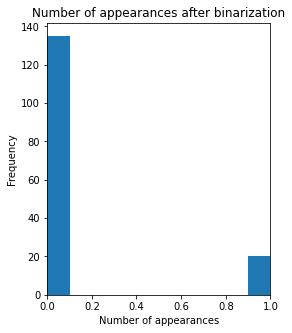

In [17]:
# initialize transformer with desired options
binarizer = Binarizer(threshold = 1000)

# save data to binarize
X = avengers[['Appearances']]

# fit transformer to data
binarizer.fit(X)

# create new feature by transforming the data
avengers['Appearances_binary'] = binarizer.transform(X)

# plot histogram
avengers['Appearances_binary'].plot.hist(figsize=(4, 5));
plt.xlim(0,1);
plt.xlabel('Number of appearances');
plt.title('Number of appearances after binarization');

### 3.1.3. Scaling of numerical data

Often, the numeric variables in our dataset have very different scales, that is, take on different ranges of values.

It's usually a good practice to **scale** them during the preprocessing of our data. These transformations change the data itself, but not the distribution. Why it is important to scale the data?
* When predictor values have different ranges, particular features can dominate the algorithm (e.g., think [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance));
* Different scales can make estimators unable to learn correctly from certain features in smaller ranges;
* You don't want your feature to rely on the scale of the measurement involved;
* Optimization methods (e.g. gradient descent) will converge faster, and otherwise they may not converge at all.

A notable exception are *decision tree-based* estimators that are robust to arbitrary scaling of the data.

Here, we present 4 different examples of scaling transformers.

#### [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)

This transforms all variables so that the minimum and the maximum of the transformed data take certain values $[a,b]$, say, [0, 1]. The general formula to scale $x_i$ from a range $[x_{\min}, x_{\max}] \to [a,b]$ is:

$$ x_i' = \frac{x_i - x_{\min}}{x_{\max} - x_{\min}} \cdot (b-a) + a $$

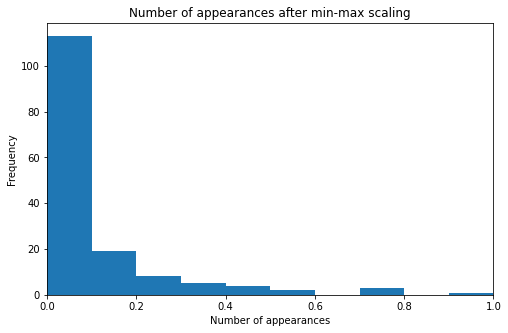

In [18]:
# initialize transformer with desired options
minmaxscaler = MinMaxScaler(feature_range=(0,1))

# save data to scale
X = avengers[['Appearances']]

# fit transformer to data
minmaxscaler.fit(X)

# create new feature by transforming the data
avengers['Appearances_minmax'] = minmaxscaler.transform(X)

# plot histogram
avengers['Appearances_minmax'].plot.hist(figsize=(8, 5));
plt.xlim(0, 1);
plt.xlabel('Number of appearances');
plt.title('Number of appearances after min-max scaling');

#### [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html)

This normalizes each ***row*** of the dataset *individually* to unit norm, independently of the other rows. You can choose between $\ell_2$ (default), $\ell_1$ and $\max$ norms.

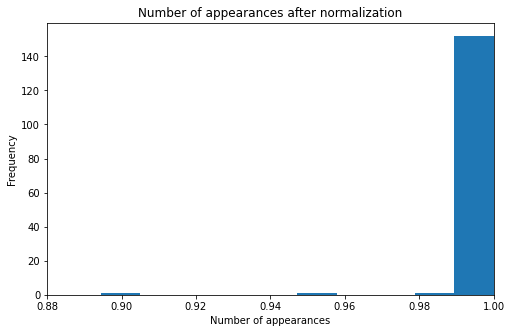

In [19]:
# initialize transformer with desired options
normalizer = Normalizer(norm='l2')

# save numerical columns to normalize
X = avengers[['Appearances', 'TotalDeaths', 'TotalReturns']]

# fit transformer to data
normalizer.fit(X)

# create new features by transforming the data
X_normalized = normalizer.transform(X)  # recall that output is a numpy array
avengers['Appearances_normalized'] = X_normalized[:, 0]
avengers['TotalDeaths_normalized'] = X_normalized[:, 1]
avengers['TotalReturns_normalized'] = X_normalized[:, 2]

# plot histogram of normalized appearances
avengers['Appearances_normalized'].plot.hist(figsize=(8, 5));
plt.xlim(0.88, 1);
plt.xlabel('Number of appearances');
plt.title('Number of appearances after normalization');

#### [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

Standardization means both centering the data around 0 (by removing the mean) and scaling it to unit variance:

$$ z_i =  \frac{x_i - \mu}{\sigma}$$

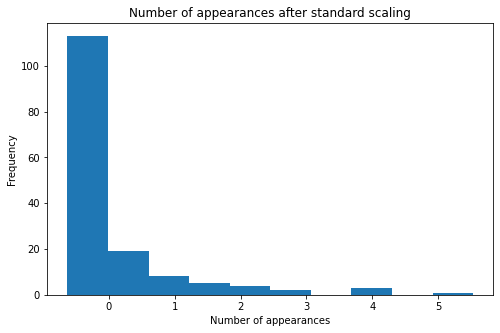

In [20]:
# initialize transformer with desired options
standardscaler = StandardScaler()

# save data to scale
X = avengers[['Appearances']]

# fit transformer to data
standardscaler.fit(X)

# create new feature by transforming the data
avengers['Appearances_standard_scaled'] = standardscaler.transform(X)

# plot histogram
avengers['Appearances_standard_scaled'].plot.hist(figsize=(8, 5));
plt.xlabel('Number of appearances');

plt.title('Number of appearances after standard scaling');

#### [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)

Scalers differ from each other in the way to estimate the parameters used to shift and scale each feature. In the presence of some very large ***outliers***, using the scaler above leads to the compression of inliers. Since outliers have an influence on the minimum, maximum, mean and standard deviation, these scalers will shrink the range of the feature values.

The alternative is to scale the features in a way that is robust to outliers: using the *median* (instead of the *mean*) and the Interquartile Range *('member SLU04?)*.

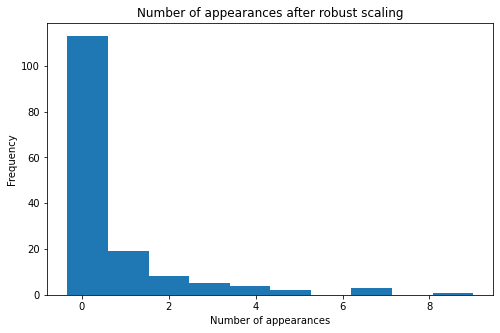

In [21]:
# initialize transformer with desired options
robustscaler = RobustScaler()

# save data to scale
X = avengers[['Appearances']]

# fit transformer to data
robustscaler.fit(X)

# create new feature by transforming the data
avengers['Appearances_robust_scaled'] = robustscaler.transform(X)

# plot histogram
avengers['Appearances_robust_scaled'].plot.hist(figsize=(8, 5));
plt.xlabel('Number of appearances');
plt.title('Number of appearances after robust scaling');

## 3.2. Dealing with categorical data <a class="anchor" id="deal-cat"></a>

Categorical data represents categories (e.g., gender, marital status, hometown).

Categorical variables can take on a limited, and usually fixed, number of possible values.

The categories can also take on numerical values (e.g., ids), but those numbers have no mathematical meaning:
* You can't do mathematical operations, even if [the computer says yes](https://www.youtube.com/watch?v=Lk1yoobIMUY);
* Nor sort them in ascending or descending order.

A limitation of categorical data in the form of strings is that estimators, in general, don't know how to deal with it.

### 3.2.1. Binary data

A binary variable is a variable with only two possible values: like `Active` and `Gender` in our `avengers` dataset.

Since our algorithms can't deal with data in the form of strings, we need to transform such variables to a numerical form.

The method `Series.map` allows us to easily deal with this cases, mapping inputs to outputs. Let's use it convert both columns to either 0 or 1.

In [22]:
avengers = pd.read_csv('data/avengers.csv')

(avengers.assign(Active_mapped = avengers['Active'].map({'YES': 1, 'NO': 0}),
                 Gender_mapped = avengers['Gender'].map({'MALE': 1, 'FEMALE': 0}))
         .sample(5))

,Name,Active,Gender,Membership,Universe,Appearances,TotalDeaths,TotalReturns,Active_mapped,Gender_mapped
8,Pietro Maximoff,YES,MALE,Full,Earth-616,769,1,1,1,1
144,"Nicholas Fury, Jr., Marcus Johnson",YES,MALE,Full,Earth-616,77,0,0,1,1
85,Maya Lopez,NO,FEMALE,Full,Earth-616,67,2,1,0,0
1,Janet van Dyne,YES,FEMALE,Full,Earth-616,1165,1,1,1,0
23,Martinex T'Naga,NO,MALE,Honorary,Earth-691,100,0,0,0,1


(See below for a transformer way to achieve the same thing.)

### 3.2.2. Enconding categorical features

There are also transformers to deal with categorical features. Even though `sklearn` contains some of such transformers, there is a (much) better library which you shoud (must!) use instead, [`category_encoders`](http://contrib.scikit-learn.org/category_encoders/):

In [23]:
import category_encoders as ce

In particular, we are going to explore the following encoders.

#### Ordinal encoding

The [`OrdinalEncoder` transformer](http://contrib.scikit-learn.org/category_encoders/ordinal.html) encodes categorical features as ordinal, integer feature. It uses a single column of integers, chosen randomly by default, to represent the classes.

For example, the `Universe` field has 7 possible values.

In [24]:
avengers.sample(5, random_state=9)

,Name,Active,Gender,Membership,Universe,Appearances,TotalDeaths,TotalReturns
73,Phillip Javert,NO,MALE,Honorary,Earth-921,31,0,0
51,Ravonna Lexus Renslayer,NO,FEMALE,Full,Earth-6311,41,2,1
89,Cassie Lang,NO,FEMALE,Full,Earth-616,160,1,1
122,Anya Corazon,YES,FEMALE,Academy,Earth-616,108,0,0
26,Stakar,NO,MALE,Honorary,Earth-691,100,0,0


In [25]:
avengers['Universe'].unique()

array(['Earth-616', 'Earth-691', 'Earth-6311', 'Earth-921', 'Earth-96020',
       'Earth-8009', 'Earth-13034'], dtype=object)

In [26]:
# initialize transformer with desired options
ordinalencoder = ce.ordinal.OrdinalEncoder()

# save data to scale (no need to reshape)
X = avengers[['Universe']]

# fit transformer to data
ordinalencoder.fit(X)

# create new feature by transforming the data
X_encoded = ordinalencoder.transform(X)
X_encoded.sample(5, random_state=9)

,Universe
73,4
51,3
89,1
122,1
26,2


If you want to see the mapping which was created:

In [27]:
ordinalencoder.category_mapping

[{'col': 'Universe',
  'mapping': Earth-616      1
  Earth-691      2
  Earth-6311     3
  Earth-921      4
  Earth-96020    5
  Earth-8009     6
  Earth-13034    7
  NaN           -2
  dtype: int64,
  'data_type': dtype('O')}]

We applied the transformation on the same data we fit the transformer. What would happen if we tried to transform an instance with an ***unseen category***, say `Earth-123` or `Earth-999`?

In [28]:
ordinalencoder.transform(pd.DataFrame({'Universe': ['Earth-6311', 'Earth-123', 'Earth-999']}))

,Universe
0,3.0
1,-1.0
2,-1.0


It automatically imputed the value `-1`. This is because, by default, the option `handle_unknown` is set to `'value'`. The transformers in `category_encoders` take care of unseen categories by themselves!

#### One-hot encoding

Ordinal enconding, as described above, creates one new feature with integers for each categorical feature. Even though the values of the integers generally have no meaning, a Machine Learning algorithm might think otherwise and decide that, for example, a category whose encoding is `8` is more important than one with `2`!

To avoid this, we can consider **one-hot encoding**, which, for each categorical feature, creates one new feature per *each category*. This can be implemented using the [`OneHotEncoder` transformer](http://contrib.scikit-learn.org/category_encoders/onehot.html).

In [29]:
# initialize transformer with desired options
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='indicator')

# save data to scale (no need to reshape)
X = avengers[['Universe']]

# fit transformer to data
ohe.fit(X)

# create new feature by transforming the data
X_ohe = ohe.transform(X)
X_ohe.sample(5, random_state=9)

,Universe_Earth-616,Universe_Earth-691,Universe_Earth-6311,Universe_Earth-921,Universe_Earth-96020,Universe_Earth-8009,Universe_Earth-13034,Universe_-1
73,0,0,0,1,0,0,0,0
51,0,0,1,0,0,0,0,0
89,1,0,0,0,0,0,0,0
122,1,0,0,0,0,0,0,0
26,0,1,0,0,0,0,0,0


Note how the names of the new features were automatically created (by using the option `use_cat_names`) and how an extra feature (`Universe_-1`) was created for unseen categories (due to the option `handle_unknown='indicator'` -- note that this is different from the Ordinal Encoder!).

# Conclusion

You now know the types of data that you will find in the real world and the options you have to manipulate data it in order to get the most of it.

Make sure to review this notebook well, and when you're ready, go solve the exercises. Good luck!